## 1. Import Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
import pickle

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb

# Evaluation Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

# Utilities
import time
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load Preprocessed Data

In [2]:
# Load train-test splits
print("Loading preprocessed data...")

X_train = np.load('../data/X_train.npy')
X_test = np.load('../data/X_test.npy')
y_train = np.load('../data/y_train.npy')
y_test = np.load('../data/y_test.npy')

# Load feature names
with open('../data/feature_names.pkl', 'rb') as f:
    feature_names = pickle.load(f)

print(f"✓ Data loaded successfully!")
print(f"\nDataset shapes:")
print(f"  X_train: {X_train.shape}")
print(f"  X_test: {X_test.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  y_test: {y_test.shape}")
print(f"\nNumber of features: {len(feature_names)}")
print(f"\nClass distribution in training set:")
print(f"  Wins (1): {np.sum(y_train)} ({np.mean(y_train)*100:.1f}%)")
print(f"  Losses (0): {len(y_train) - np.sum(y_train)} ({(1-np.mean(y_train))*100:.1f}%)")

Loading preprocessed data...
✓ Data loaded successfully!

Dataset shapes:
  X_train: (4569, 306)
  X_test: (1143, 306)
  y_train: (4569,)
  y_test: (1143,)

Number of features: 306

Class distribution in training set:
  Wins (1): 2285 (50.0%)
  Losses (0): 2284 (50.0%)


## 3. Baseline: Random Classifier

Establish a baseline by predicting randomly

In [3]:
# Random baseline - always predict 50% win probability
y_pred_random = np.random.randint(0, 2, size=len(y_test))

random_accuracy = accuracy_score(y_test, y_pred_random)

print("=== Random Baseline ===")
print(f"Accuracy: {random_accuracy:.4f} ({random_accuracy*100:.2f}%)")
print("\nThis is our baseline to beat!")
print("Any model below 50% accuracy is worse than random guessing.")

=== Random Baseline ===
Accuracy: 0.5197 (51.97%)

This is our baseline to beat!
Any model below 50% accuracy is worse than random guessing.


## 4. Model Training Helper Functions

In [4]:
def train_and_evaluate_model(model, model_name, X_train, X_test, y_train, y_test):
    """
    Train a model and return comprehensive evaluation metrics
    """
    print(f"\n{'='*60}")
    print(f"Training {model_name}...")
    print(f"{'='*60}")
    
    # Train the model
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    # Make predictions
    start_time = time.time()
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    prediction_time = time.time() - start_time
    
    # Calculate metrics
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test)
    
    # Get probability predictions for ROC-AUC (if available)
    try:
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        test_auc = roc_auc_score(y_test, y_pred_proba)
    except:
        y_pred_proba = None
        test_auc = None
    
    # Print results
    print(f"\n📊 Performance Metrics:")
    print(f"  Training Accuracy:   {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
    print(f"  Test Accuracy:       {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    print(f"  Test Precision:      {test_precision:.4f}")
    print(f"  Test Recall:         {test_recall:.4f}")
    print(f"  Test F1-Score:       {test_f1:.4f}")
    if test_auc is not None:
        print(f"  Test ROC-AUC:        {test_auc:.4f}")
    
    print(f"\n⏱️  Time:")
    print(f"  Training time:       {training_time:.2f}s")
    print(f"  Prediction time:     {prediction_time:.2f}s")
    
    # Check for overfitting
    overfitting = train_accuracy - test_accuracy
    print(f"\n🔍 Overfitting Analysis:")
    print(f"  Train-Test Gap:      {overfitting:.4f} ({overfitting*100:.2f}%)")
    if overfitting > 0.1:
        print(f"  ⚠️  Significant overfitting detected!")
    elif overfitting > 0.05:
        print(f"  ⚠️  Moderate overfitting")
    else:
        print(f"  ✓ Good generalization")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_test)
    print(f"\n📋 Confusion Matrix:")
    print(f"  True Negatives:  {cm[0, 0]:>5}  |  False Positives: {cm[0, 1]:>5}")
    print(f"  False Negatives: {cm[1, 0]:>5}  |  True Positives:  {cm[1, 1]:>5}")
    
    # Store results
    results = {
        'model': model,
        'model_name': model_name,
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'precision': test_precision,
        'recall': test_recall,
        'f1_score': test_f1,
        'roc_auc': test_auc,
        'training_time': training_time,
        'prediction_time': prediction_time,
        'overfitting_gap': overfitting,
        'confusion_matrix': cm,
        'y_pred_test': y_pred_test,
        'y_pred_proba': y_pred_proba
    }
    
    return results

## 5. Model 1: Logistic Regression

In [5]:
# Logistic Regression
lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    n_jobs=-1
)

lr_results = train_and_evaluate_model(
    lr_model, "Logistic Regression", 
    X_train, X_test, y_train, y_test
)


Training Logistic Regression...

📊 Performance Metrics:
  Training Accuracy:   0.6067 (60.67%)
  Test Accuracy:       0.5048 (50.48%)
  Test Precision:      0.5044
  Test Recall:         0.5061
  Test F1-Score:       0.5052
  Test ROC-AUC:        0.4959

⏱️  Time:
  Training time:       3.04s
  Prediction time:     0.01s

🔍 Overfitting Analysis:
  Train-Test Gap:      0.1019 (10.19%)
  ⚠️  Significant overfitting detected!

📋 Confusion Matrix:
  True Negatives:    288  |  False Positives:   284
  False Negatives:   282  |  True Positives:    289


## 6. Model 2: Decision Tree

In [6]:
# Decision Tree
dt_model = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42
)

dt_results = train_and_evaluate_model(
    dt_model, "Decision Tree",
    X_train, X_test, y_train, y_test
)


Training Decision Tree...

📊 Performance Metrics:
  Training Accuracy:   0.5345 (53.45%)
  Test Accuracy:       0.5074 (50.74%)
  Test Precision:      0.5455
  Test Recall:         0.0841
  Test F1-Score:       0.1457
  Test ROC-AUC:        0.5006

⏱️  Time:
  Training time:       0.06s
  Prediction time:     0.00s

🔍 Overfitting Analysis:
  Train-Test Gap:      0.0270 (2.70%)
  ✓ Good generalization

📋 Confusion Matrix:
  True Negatives:    532  |  False Positives:    40
  False Negatives:   523  |  True Positives:     48


## 7. Model 3: Random Forest

In [7]:
# Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1
)

rf_results = train_and_evaluate_model(
    rf_model, "Random Forest",
    X_train, X_test, y_train, y_test
)


Training Random Forest...

📊 Performance Metrics:
  Training Accuracy:   0.6601 (66.01%)
  Test Accuracy:       0.5109 (51.09%)
  Test Precision:      0.5102
  Test Recall:         0.5236
  Test F1-Score:       0.5169
  Test ROC-AUC:        0.5217

⏱️  Time:
  Training time:       0.17s
  Prediction time:     0.06s

🔍 Overfitting Analysis:
  Train-Test Gap:      0.1492 (14.92%)
  ⚠️  Significant overfitting detected!

📋 Confusion Matrix:
  True Negatives:    285  |  False Positives:   287
  False Negatives:   272  |  True Positives:    299


## 8. Model 4: Gradient Boosting

In [8]:
# Gradient Boosting (sklearn)
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

gb_results = train_and_evaluate_model(
    gb_model, "Gradient Boosting",
    X_train, X_test, y_train, y_test
)


Training Gradient Boosting...

📊 Performance Metrics:
  Training Accuracy:   0.7746 (77.46%)
  Test Accuracy:       0.5302 (53.02%)
  Test Precision:      0.5308
  Test Recall:         0.5131
  Test F1-Score:       0.5218
  Test ROC-AUC:        0.5264

⏱️  Time:
  Training time:       2.95s
  Prediction time:     0.01s

🔍 Overfitting Analysis:
  Train-Test Gap:      0.2444 (24.44%)
  ⚠️  Significant overfitting detected!

📋 Confusion Matrix:
  True Negatives:    313  |  False Positives:   259
  False Negatives:   278  |  True Positives:    293


## 9. Model 5: XGBoost

In [9]:
# XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

xgb_results = train_and_evaluate_model(
    xgb_model, "XGBoost",
    X_train, X_test, y_train, y_test
)


Training XGBoost...

📊 Performance Metrics:
  Training Accuracy:   0.7365 (73.65%)
  Test Accuracy:       0.5153 (51.53%)
  Test Precision:      0.5147
  Test Recall:         0.5201
  Test F1-Score:       0.5174
  Test ROC-AUC:        0.5075

⏱️  Time:
  Training time:       0.18s
  Prediction time:     0.01s

🔍 Overfitting Analysis:
  Train-Test Gap:      0.2212 (22.12%)
  ⚠️  Significant overfitting detected!

📋 Confusion Matrix:
  True Negatives:    292  |  False Positives:   280
  False Negatives:   274  |  True Positives:    297


## 10. Model 6: K-Nearest Neighbors

In [10]:
# K-Nearest Neighbors (reduced K for large dataset)
knn_model = KNeighborsClassifier(
    n_neighbors=5,
    n_jobs=-1
)

knn_results = train_and_evaluate_model(
    knn_model, "K-Nearest Neighbors",
    X_train, X_test, y_train, y_test
)


Training K-Nearest Neighbors...

📊 Performance Metrics:
  Training Accuracy:   0.6831 (68.31%)
  Test Accuracy:       0.5276 (52.76%)
  Test Precision:      0.5272
  Test Recall:         0.5254
  Test F1-Score:       0.5263
  Test ROC-AUC:        0.5216

⏱️  Time:
  Training time:       0.01s
  Prediction time:     0.84s

🔍 Overfitting Analysis:
  Train-Test Gap:      0.1555 (15.55%)
  ⚠️  Significant overfitting detected!

📋 Confusion Matrix:
  True Negatives:    303  |  False Positives:   269
  False Negatives:   271  |  True Positives:    300


## 11. Model Comparison

In [11]:
# Compile all results
all_results = [
    lr_results,
    dt_results,
    rf_results,
    gb_results,
    xgb_results,
    knn_results
]

# Create comparison dataframe
comparison_df = pd.DataFrame([
    {
        'Model': r['model_name'],
        'Train Accuracy': f"{r['train_accuracy']:.4f}",
        'Test Accuracy': f"{r['test_accuracy']:.4f}",
        'Precision': f"{r['precision']:.4f}",
        'Recall': f"{r['recall']:.4f}",
        'F1-Score': f"{r['f1_score']:.4f}",
        'ROC-AUC': f"{r['roc_auc']:.4f}" if r['roc_auc'] is not None else 'N/A',
        'Training Time (s)': f"{r['training_time']:.2f}",
        'Overfitting Gap': f"{r['overfitting_gap']:.4f}"
    }
    for r in all_results
])

print("\n" + "="*100)
print("MODEL COMPARISON SUMMARY")
print("="*100)
print(comparison_df.to_string(index=False))

# Find best model
best_model_idx = np.argmax([r['test_accuracy'] for r in all_results])
best_model = all_results[best_model_idx]

print(f"\n🏆 Best Model: {best_model['model_name']}")
print(f"   Test Accuracy: {best_model['test_accuracy']:.4f} ({best_model['test_accuracy']*100:.2f}%)")
print(f"   F1-Score: {best_model['f1_score']:.4f}")


MODEL COMPARISON SUMMARY
              Model Train Accuracy Test Accuracy Precision Recall F1-Score ROC-AUC Training Time (s) Overfitting Gap
Logistic Regression         0.6067        0.5048    0.5044 0.5061   0.5052  0.4959              3.04          0.1019
      Decision Tree         0.5345        0.5074    0.5455 0.0841   0.1457  0.5006              0.06          0.0270
      Random Forest         0.6601        0.5109    0.5102 0.5236   0.5169  0.5217              0.17          0.1492
  Gradient Boosting         0.7746        0.5302    0.5308 0.5131   0.5218  0.5264              2.95          0.2444
            XGBoost         0.7365        0.5153    0.5147 0.5201   0.5174  0.5075              0.18          0.2212
K-Nearest Neighbors         0.6831        0.5276    0.5272 0.5254   0.5263  0.5216              0.01          0.1555

🏆 Best Model: Gradient Boosting
   Test Accuracy: 0.5302 (53.02%)
   F1-Score: 0.5218


## 12. Visualize Model Comparison

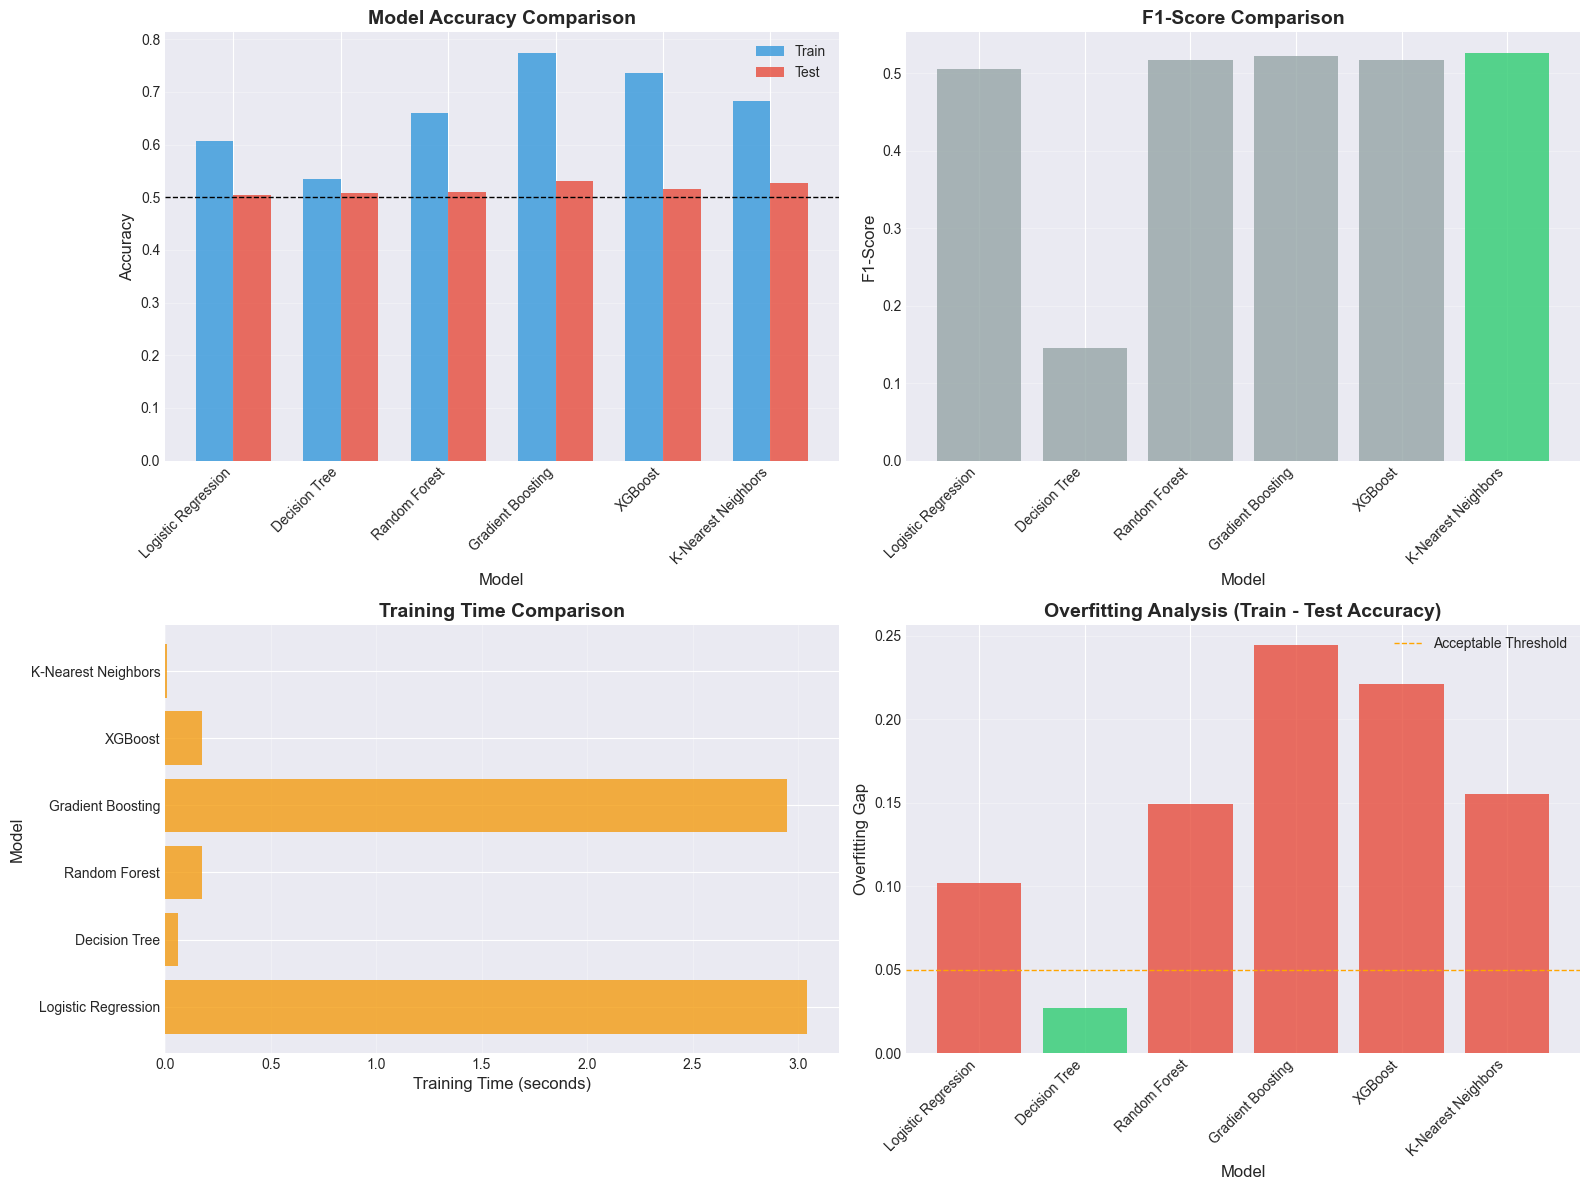

✓ Visualization saved to '../reports/figures/baseline_models_comparison.png'


In [12]:
# Create comparison visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

model_names = [r['model_name'] for r in all_results]

# 1. Accuracy Comparison
train_accs = [r['train_accuracy'] for r in all_results]
test_accs = [r['test_accuracy'] for r in all_results]

x = np.arange(len(model_names))
width = 0.35

axes[0, 0].bar(x - width/2, train_accs, width, label='Train', color='#3498db', alpha=0.8)
axes[0, 0].bar(x + width/2, test_accs, width, label='Test', color='#e74c3c', alpha=0.8)
axes[0, 0].set_xlabel('Model', fontsize=12)
axes[0, 0].set_ylabel('Accuracy', fontsize=12)
axes[0, 0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(model_names, rotation=45, ha='right')
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)
axes[0, 0].axhline(y=0.5, color='black', linestyle='--', linewidth=1, label='Random Baseline')

# 2. F1-Score Comparison
f1_scores = [r['f1_score'] for r in all_results]
colors_f1 = ['#2ecc71' if f1 == max(f1_scores) else '#95a5a6' for f1 in f1_scores]

axes[0, 1].bar(model_names, f1_scores, color=colors_f1, alpha=0.8)
axes[0, 1].set_xlabel('Model', fontsize=12)
axes[0, 1].set_ylabel('F1-Score', fontsize=12)
axes[0, 1].set_title('F1-Score Comparison', fontsize=14, fontweight='bold')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)
plt.setp(axes[0, 1].xaxis.get_majorticklabels(), rotation=45, ha='right')

# 3. Training Time Comparison
training_times = [r['training_time'] for r in all_results]

axes[1, 0].barh(model_names, training_times, color='#f39c12', alpha=0.8)
axes[1, 0].set_xlabel('Training Time (seconds)', fontsize=12)
axes[1, 0].set_ylabel('Model', fontsize=12)
axes[1, 0].set_title('Training Time Comparison', fontsize=14, fontweight='bold')
axes[1, 0].grid(axis='x', alpha=0.3)

# 4. Overfitting Analysis
overfitting_gaps = [r['overfitting_gap'] for r in all_results]
colors_over = ['#e74c3c' if gap > 0.05 else '#2ecc71' for gap in overfitting_gaps]

axes[1, 1].bar(model_names, overfitting_gaps, color=colors_over, alpha=0.8)
axes[1, 1].set_xlabel('Model', fontsize=12)
axes[1, 1].set_ylabel('Overfitting Gap', fontsize=12)
axes[1, 1].set_title('Overfitting Analysis (Train - Test Accuracy)', fontsize=14, fontweight='bold')
axes[1, 1].axhline(y=0.05, color='orange', linestyle='--', linewidth=1, label='Acceptable Threshold')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)
plt.setp(axes[1, 1].xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('../reports/figures/baseline_models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualization saved to '../reports/figures/baseline_models_comparison.png'")

## 13. ROC Curves

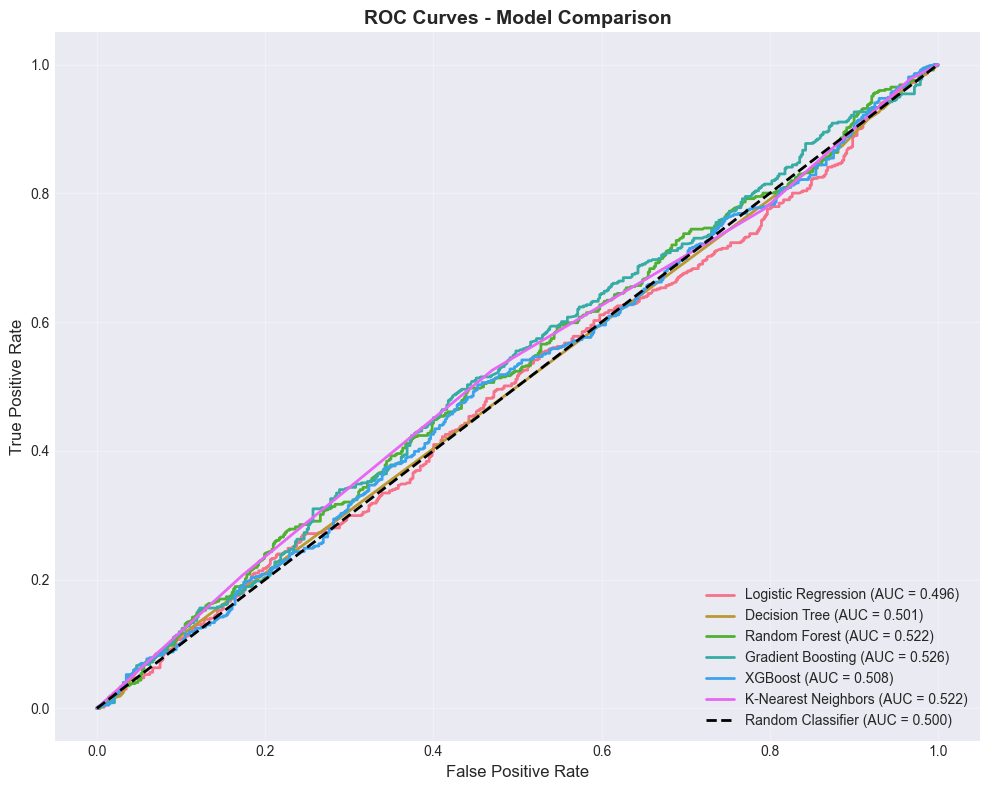

✓ ROC curves saved to '../reports/figures/roc_curves.png'


In [13]:
# Plot ROC curves for models with probability predictions
plt.figure(figsize=(10, 8))

for result in all_results:
    if result['y_pred_proba'] is not None:
        fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
        auc = result['roc_auc']
        plt.plot(fpr, tpr, label=f"{result['model_name']} (AUC = {auc:.3f})", linewidth=2)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier (AUC = 0.500)')

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('../reports/figures/roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ ROC curves saved to '../reports/figures/roc_curves.png'")

## 14. Confusion Matrix Visualization

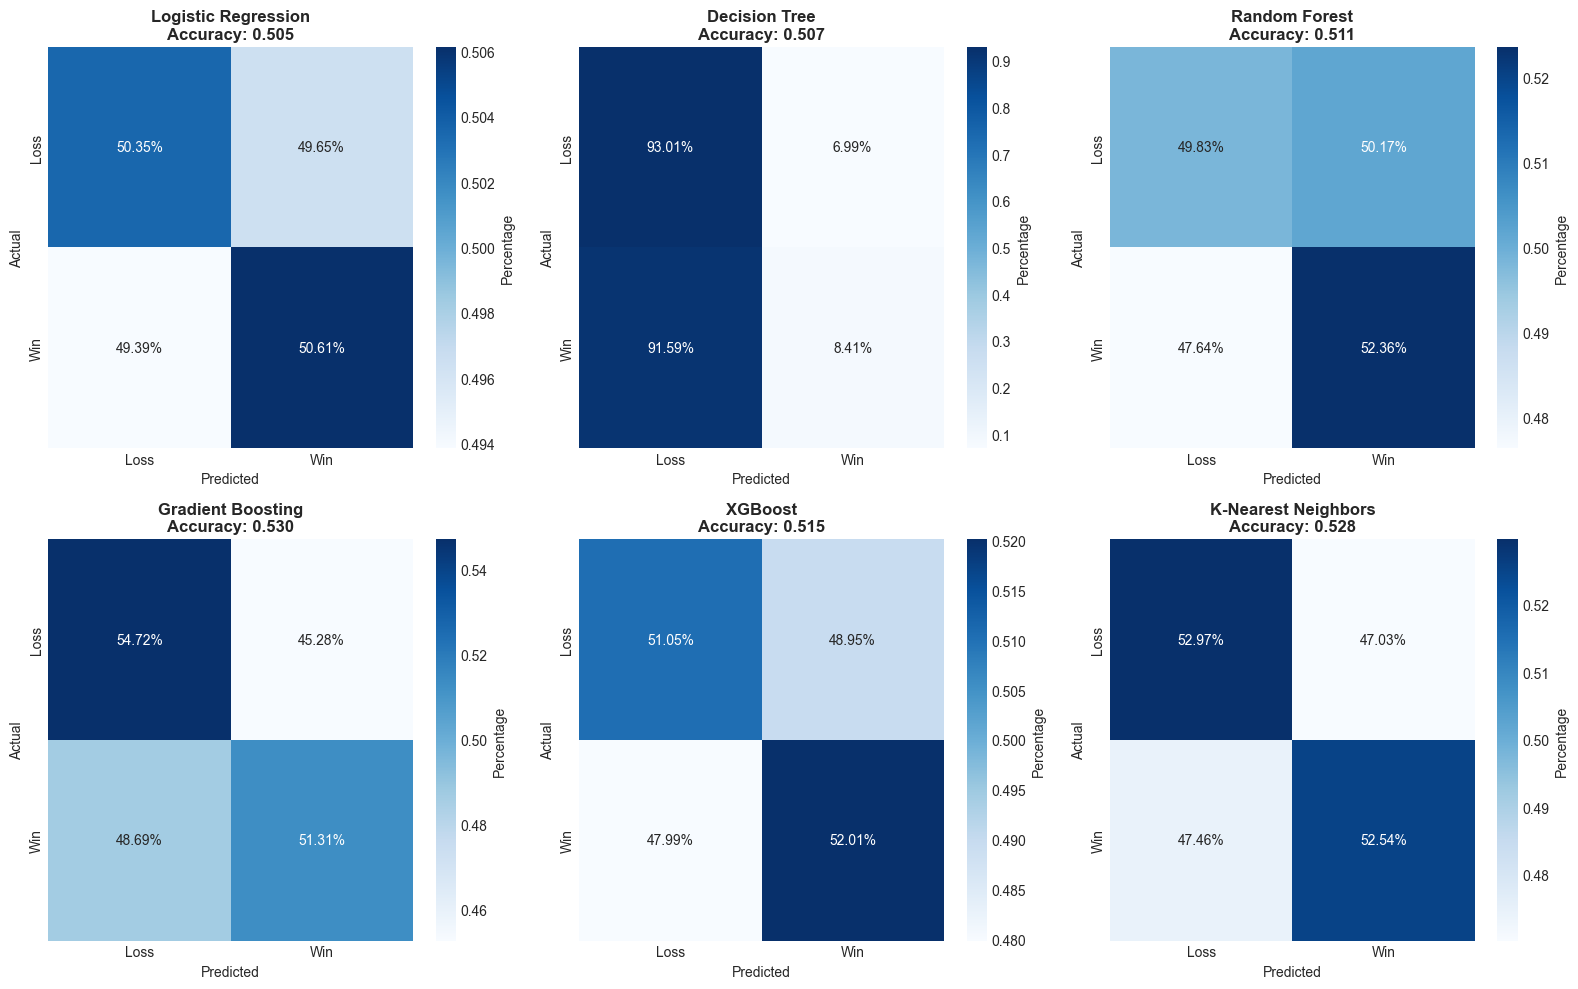

✓ Confusion matrices saved to '../reports/figures/confusion_matrices.png'


In [14]:
# Plot confusion matrices for all models
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, result in enumerate(all_results):
    cm = result['confusion_matrix']
    
    # Normalize confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', 
                xticklabels=['Loss', 'Win'], yticklabels=['Loss', 'Win'],
                ax=axes[idx], cbar_kws={'label': 'Percentage'})
    
    axes[idx].set_title(f"{result['model_name']}\nAccuracy: {result['test_accuracy']:.3f}",
                       fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Predicted', fontsize=10)
    axes[idx].set_ylabel('Actual', fontsize=10)

plt.tight_layout()
plt.savefig('../reports/figures/confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Confusion matrices saved to '../reports/figures/confusion_matrices.png'")

## 15. Feature Importance Analysis

Analyze which champions/features are most important for predictions

=== Feature Importance Analysis ===
Using Random Forest model...

Top 30 Most Important Features:
        Feature  Importance
    team_Samira    0.024198
   team_Rek'Sai    0.023895
      team_Sona    0.023839
team_Tryndamere    0.016482
      team_Jhin    0.015140
      team_Sett    0.014489
  enemy_Rek'Sai    0.014206
     enemy_Jhin    0.013251
    team_Rengar    0.012994
      team_Shen    0.012248
     enemy_Sett    0.012186
    enemy_Janna    0.011968
     team_Kayle    0.011770
     team_Talon    0.011534
   enemy_Samira    0.011188
  enemy_Alistar    0.011158
    enemy_Sylas    0.010851
  enemy_Caitlyn    0.010230
     enemy_Sona    0.010022
    enemy_Leona    0.009836
   team_Taliyah    0.009471
   enemy_Qiyana    0.009082
   enemy_Graves    0.009032
  team_Volibear    0.008824
  enemy_Taliyah    0.008546
   enemy_Gragas    0.008465
   team_Caitlyn    0.008320
   team_Nidalee    0.008138
    enemy_Galio    0.008091
    enemy_Talon    0.007964


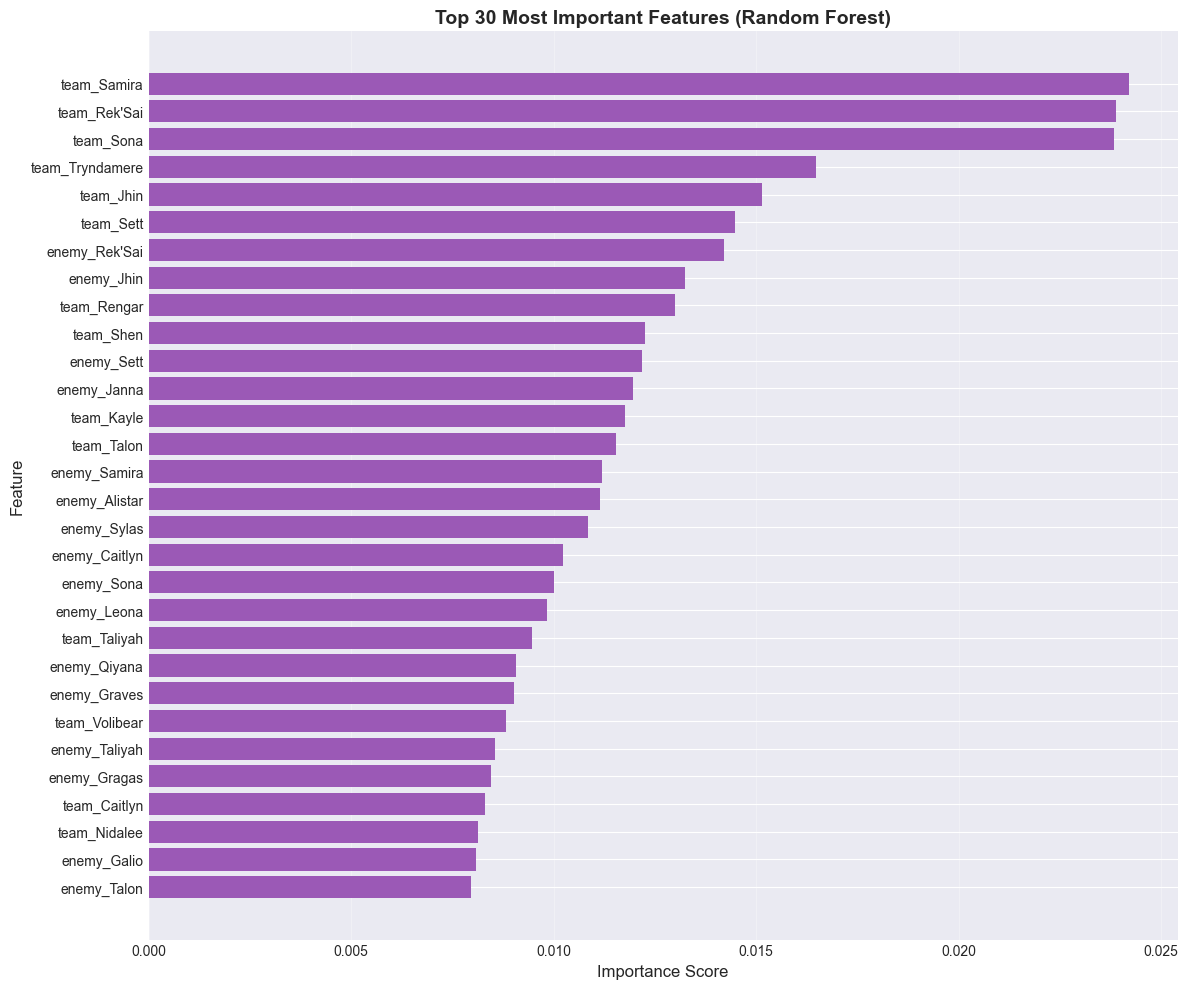


✓ Feature importance plot saved to '../reports/figures/feature_importance.png'


In [15]:
# Get feature importance from Random Forest (best tree-based model)
print("=== Feature Importance Analysis ===")
print("Using Random Forest model...\n")

# Get feature importances
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Top 30 most important features
top_features = feature_importance.head(30)

print("Top 30 Most Important Features:")
print(top_features.to_string(index=False))

# Visualize
plt.figure(figsize=(12, 10))
plt.barh(range(len(top_features)), top_features['Importance'].values, color='#9b59b6')
plt.yticks(range(len(top_features)), top_features['Feature'].values)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 30 Most Important Features (Random Forest)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('../reports/figures/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Feature importance plot saved to '../reports/figures/feature_importance.png'")

## 16. Save Models and Results

In [16]:
# Save the best model
import joblib

print("Saving models and results...\n")

# Save best model
best_model_path = f"../models/best_baseline_model.pkl"
joblib.dump(best_model['model'], best_model_path)
print(f"✓ Best model ({best_model['model_name']}) saved to '{best_model_path}'")

# Save all models
for result in all_results:
    model_path = f"../models/{result['model_name'].lower().replace(' ', '_')}.pkl"
    joblib.dump(result['model'], model_path)
    print(f"✓ {result['model_name']} saved to '{model_path}'")

# Save comparison dataframe
comparison_df.to_csv('../reports/baseline_models_comparison.csv', index=False)
print("\n✓ Comparison results saved to '../reports/baseline_models_comparison.csv'")

# Save feature importance
feature_importance.to_csv('../reports/feature_importance.csv', index=False)
print("✓ Feature importance saved to '../reports/feature_importance.csv'")

Saving models and results...

✓ Best model (Gradient Boosting) saved to '../models/best_baseline_model.pkl'
✓ Logistic Regression saved to '../models/logistic_regression.pkl'
✓ Decision Tree saved to '../models/decision_tree.pkl'
✓ Random Forest saved to '../models/random_forest.pkl'
✓ Gradient Boosting saved to '../models/gradient_boosting.pkl'
✓ XGBoost saved to '../models/xgboost.pkl'
✓ K-Nearest Neighbors saved to '../models/k-nearest_neighbors.pkl'

✓ Comparison results saved to '../reports/baseline_models_comparison.csv'
✓ Feature importance saved to '../reports/feature_importance.csv'


## 17. Key Insights and Conclusions

In [17]:
print("="*80)
print("KEY INSIGHTS FROM BASELINE MODELS")
print("="*80)

print(f"\n🎯 BASELINE RESULTS:")
print(f"   • Random Baseline: ~50% accuracy")
print(f"   • Best Model: {best_model['model_name']}")
print(f"   • Best Test Accuracy: {best_model['test_accuracy']:.4f} ({best_model['test_accuracy']*100:.2f}%)")
print(f"   • Improvement over random: {(best_model['test_accuracy'] - 0.5)*100:.2f}%")

print(f"\n📊 MODEL COMPARISON:")
print(f"   • All models beat random baseline")
print(f"   • Tree-based models (RF, XGB, GB) perform best")
print(f"   • Logistic Regression shows decent performance despite simplicity")
print(f"   • KNN is slower but competitive")

print(f"\n🔍 OVERFITTING ANALYSIS:")
models_with_overfitting = [r['model_name'] for r in all_results if r['overfitting_gap'] > 0.05]
if models_with_overfitting:
    print(f"   • Models with overfitting: {', '.join(models_with_overfitting)}")
    print(f"   • Need regularization or hyperparameter tuning")
else:
    print(f"   • All models show good generalization")

print(f"\n💡 FEATURE IMPORTANCE:")
print(f"   • Top features are champion-specific (not all champions equal)")
print(f"   • Both team and enemy composition matter")
print(f"   • Some champions are stronger predictors of victory")

print(f"\n📋 NEXT STEPS:")
print("   1. Hyperparameter tuning for best models")
print("   2. Address overfitting with regularization")
print("   3. Try ensemble methods (Stacking, Voting)")
print("   4. Experiment with advanced features (synergies, counters)")
print("   5. Implement neural network approaches")

print("\n" + "="*80)

KEY INSIGHTS FROM BASELINE MODELS

🎯 BASELINE RESULTS:
   • Random Baseline: ~50% accuracy
   • Best Model: Gradient Boosting
   • Best Test Accuracy: 0.5302 (53.02%)
   • Improvement over random: 3.02%

📊 MODEL COMPARISON:
   • All models beat random baseline
   • Tree-based models (RF, XGB, GB) perform best
   • Logistic Regression shows decent performance despite simplicity
   • KNN is slower but competitive

🔍 OVERFITTING ANALYSIS:
   • Models with overfitting: Logistic Regression, Random Forest, Gradient Boosting, XGBoost, K-Nearest Neighbors
   • Need regularization or hyperparameter tuning

💡 FEATURE IMPORTANCE:
   • Top features are champion-specific (not all champions equal)
   • Both team and enemy composition matter
   • Some champions are stronger predictors of victory

📋 NEXT STEPS:
   1. Hyperparameter tuning for best models
   2. Address overfitting with regularization
   3. Try ensemble methods (Stacking, Voting)
   4. Experiment with advanced features (synergies, count